<a href="https://colab.research.google.com/github/Dawson-Stutzman/DatasetGenerator/blob/main/DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup

In [ ]:
!pip install pyspark
#from google.colab import drive
#drive.mount('/content/gdrive')
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from pyspark.sql.types import *
from numpy.lib import math as M
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Window, SQLContext
from pyspark.sql import functions as F
import os
import random
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pyspark.sql.functions import udf, struct, when, exp, pow, lit, least, round as sqlround, sum as sqlsum
# round and sum are default functions, so the sqlsum and sqlround names are needed to differentiate
conf = SparkConf().setAppName("AppGen")
sc=SparkContext(conf=conf)
sc.setLogLevel("WARN")
sqlContext = SQLContext(sc)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d53478905cddff2d4e2a8c8a778ca89fabc153879e340d6f989cd45cd7957804
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Censor Equation Definitions (Needs events fitted)

In [ ]:
def Time_Dependency(t: float, c: int, beta: float):
  return ((t**2) * M.exp((c + (beta/2) )* t))

class EventObj:
  def __init__(self, alpha=float, dose_Beta=float, smoke_Beta=float, econ_Beta=float, sex_Beta=float, c=float):
    self.alpha = alpha
    self.dose_Beta = dose_Beta
    self.smoke_Beta = smoke_Beta
    self.econ_Beta = econ_Beta
    self.sex_Beta = sex_Beta
    self.c = c

def Event(t0, dose, smoke, econ, sex, event_params=EventObj):
  t1 = t0+1
  u = np.log(random.uniform(0, 1))
  cov = (event_params.c + (event_params.dose_Beta/2) ) # cov represents c'
  A = event_params.alpha * M.exp((event_params.dose_Beta * dose)+( event_params.smoke_Beta * smoke)+(event_params.econ_Beta * econ)+(event_params.sex_Beta * sex))
  F0 = ((cov*t0 * (cov*t0 - 2) + 2) * M.exp(t0 * cov)) / M.pow(cov, 3)
  F1 = ((cov*t1 * (cov*t1 - 2) + 2) * M.exp(t1 * cov)) / M.pow(cov, 3)
  x = (F1 - F0)-(-u / A)
  tl = t0
  th = t1
  Fl = ((cov*tl * (cov*tl - 2) + 2) * M.exp(tl * cov)) / M.pow(cov, 3)
  Fh = ((cov*th * (cov*th - 2) + 2) * M.exp(th * cov)) / M.pow(cov, 3)
  t1 = (tl+th)/2
  F1 = ((cov*t1 * (cov*t1 - 2) + 2) * M.exp(t1 * cov)) / M.pow(cov, 3)
  x = (F1 - F0)-(-u / A)
  count=0
  while (abs(x)> 0.01):
    count+=1
    #print([t0,tl,t1,th,x])
    Fl = ((cov*tl * (cov*tl - 2) + 2) * M.exp(tl * cov)) / M.pow(cov, 3)
    Fh = ((cov*th * (cov*th - 2) + 2) * M.exp(th * cov)) / M.pow(cov, 3)
    if (Fh-F0)<-u/A: #Upper estimate is too low
      #print("Shifting Interval Upwards")
      tl = th #shifts the interval up
      th = tl + (t1-t0)
      t1 = (tl+th)/2
      F1 = ((cov*t1 * (cov*t1 - 2) + 2) * M.exp(t1 * cov)) / M.pow(cov, 3)
      x = (F1 - F0)-(-u / A)
    elif ((Fl-F0)<-u/A):
      #assert , "Lower estimate is also too high"
      #The lower bound is below and the upper bound is above, so we assume the zero lies between
      if (F1-F0)<-u/A: #The midpoint is also below
        tl=t1 #we move the lower bound up
        #print("Setting Lower Bound as Midpoint")
        t1 = (tl+th)/2
        F1 = ((cov*t1 * (cov*t1 - 2) + 2) * M.exp(t1 * cov)) / M.pow(cov, 3)
        x = (F1 - F0)-(-u / A)
      else: #The midpoint is also above
        th=t1 #we move the upper bound down
        #print("Setting Higher Bound as Midpoint")
        t1 = (tl+th)/2
        F1 = ((cov*t1 * (cov*t1 - 2) + 2) * M.exp(t1 * cov)) / M.pow(cov, 3)
        x = (F1 - F0)-(-u / A)
    else: return t1
  return t1

Min value: 35.0001220703125


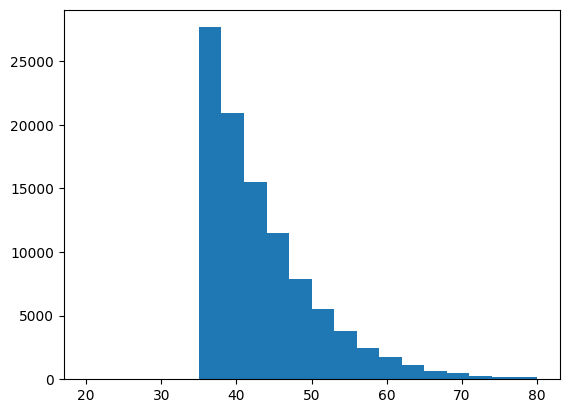

In [ ]:
data = []
Age = 35 # changing this can show different aged individuals, but the final value is never less than Age
for i in range(100000):
  E1 = EventObj(alpha=(1/5000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
  x = Event(t0=Age, dose=0.6, smoke=0, econ=2, sex=0, event_params=E1)
  data.append(x)

cols = range(20)
plt.hist(data, range=[12, 80], bins=[20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80])
print("Min value: " + str(min(data)))

# Dataset Generation Function Definition

In [ ]:
def Create_Dataset(set_size, input=None, output=None, decimal_precision=None, sort=None, ascending=None):
  """Creates a dataset of random individuals which are then censored via the hazard function definitions
  - set_size: The number of individuals to represent (affects person years)
  - input: Specifies where the input .parquet file should be read from. If left empty, the function will create its own starting data to censor
  - output: Specifies where the output .parquet file should be written and Overwritten. If left Empty, Dataset will print to console
  - decimal_Precision: The number of decimal places to round to
  """
  #Once events have been fitted, these will be set accordingly rather than specifying covariates in method parameters
  e1_params=EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
  e2_params=EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
  e3_params=EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)

  ##### Decimal Precision has a default of 12, thus returning the same values when Decimal_Precision is null
  if decimal_precision is None: decimal_precision = 12 # Set the decimal place precision for the output
  data = [] # Check if the input Parameter is used and provides a path to a .parquet file

  for i in range(0,  set_size):
    dx = 0.1
    entrance_age = random.randint(18, 25)
    seed = random.randint(0, 1000000)
    Random.seed(seed)
    dose = Random.rand()
    age = entrance_age+1
    sex = Random.randint(0, 2)
    smoker_status = Random.randint(0, 3)
    econ_status = Random.randint(0, 7)
    Included = 1
    event_1 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e1_params)
    event_2 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e2_params)
    event_3 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e3_params)
    min_event = min(event_3, event_2, event_1, 80.0)
    event = 0
    if min_event < age:
      Included = 0
      if (event_1<age):
        event=1
      elif event_2<age:
        event=2
      elif event_3<age:
        event=3
    data.append({"-ID": i,
                  "Included": Included,
                  "Smoker_Status": smoker_status,
                  "Entrance_Age": round(entrance_age, decimal_precision),
                  "Age": round(age, decimal_precision),
                  "Dosage": round(dose, decimal_precision),
                  "Sex": sex,
                  "Economic_Status": econ_status,
                  "Dosage_Seed": seed,
                  "Event1": round(event_1, decimal_precision), "Event2": round(event_2, decimal_precision), "Event3": round(event_3, decimal_precision),
                  "Earliest_Event_Age": round(min_event, decimal_precision),
                  "Event": event})
    #for each person loop through until their exit age occurs in the coming year
    while age < 80 and Included == 1:
      entrance_age = age
      age += 1
      dose += Random.uniform(0, 1)
      event_1 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e1_params)
      event_2 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e2_params)
      event_3 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e3_params)
      min_event = min(event_3, event_2, event_1, 80.0)
      if min_event < age:
        Included = 0
        if (event_1<age):
          event=1
        elif event_2<age:
          event=2
        elif event_3<age:
          event=3
      data.append({"-ID": i,
                    "Included": Included,
                    "Smoker_Status": smoker_status,
                    "Entrance_Age": round(entrance_age, decimal_precision),
                    "Age": round(age, decimal_precision),
                    "Dosage": round(dose, decimal_precision),
                    "Sex": sex,
                    "Economic_Status": econ_status,
                    "Dosage_Seed": seed,
                    "Event1": round(event_1, decimal_precision),
                    "Event2": round(event_2, decimal_precision),
                    "Event3": round(event_3, decimal_precision),
                    "Earliest_Event_Age": round(min_event, decimal_precision),
                    "Event": event})
  RDD = sc.parallelize(data)
  EventRDD = RDD.map(lambda x:
                        (x["-ID"],
                        x["Included"],
                        x["Smoker_Status"],
                        x["Entrance_Age"],
                        x["Age"],
                        x["Dosage"],
                        x["Sex"],
                        x["Economic_Status"],
                        x["Dosage_Seed"],
                        x["Event1"],
                        x["Event2"],
                        x["Event3"],
                        x["Earliest_Event_Age"],
                        x["Event"]))
  df = EventRDD.toDF(["-ID", "Included", "Smoker_Status", "Entrance_Age", "Age", "Dosage", "Sex", "Economic_Status", "Dosage_Seed", "Event1", "Event2", "Event3", "Earliest_Event_Age","Event"])
  df = df.withColumn("Dosage", sqlround(df["Dosage"], decimal_precision))
  df = df.withColumn("Entrance_Age", sqlround(df["Entrance_Age"], decimal_precision))

  if sort != None:
    if ascending == None: ascending = False
    df = df.orderBy(sort, ascending=ascending)
  else:
    if ascending == None:
      ascending = False
      df = df.orderBy('-ID', ascending=True)
    if ascending == True and sort==None:
      df = df.orderBy('-ID', ascending=False)
  if output is None:
    print()
    return df
  elif output == "print" or output == 'p':
    df.show()
  else:
    df.write.parquet(output, 'overwrite')

# Testing Code Functionality

In [ ]:
def Test_Dataset_Values(set_size, e1_params=EventObj, e2_params=EventObj, e3_params=EventObj, input=None, output=None, decimal_precision=None, sort=None, ascending=None):
  """Creates a dataset of random individuals which are then censored via the hazard function definitions
  - set_size: The number of individuals to represent (affects person years)
  - input: Specifies where the input .parquet file should be read from. If left empty, the function will create its own starting data to censor
  - output: Specifies where the output .parquet file should be written and Overwritten. If left Empty, Dataset will print to console
  - decimal_Precision: The number of decimal places to round to
  """
  ##### Decimal Precision has a default of 12, thus returning the same values when Decimal_Precision is null
  if decimal_precision is None: decimal_precision = 12 # Set the decimal place precision for the output
  data = [] # Check if the input Parameter is used and provides a path to a .parquet file

  # Loop through every individual which will need to be generated
  for i in range(0,  set_size):
    entrance_age = random.randint(18, 25)
    dose = random.random()
    age = entrance_age+1
    sex = random.randint(0, 2)
    smoker_status = random.randint(0, 3)
    econ_status = random.randint(0, 7)
    Included = 1
    event_1 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e1_params)
    event_2 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e2_params)
    event_3 = Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                            event_params=e3_params)
    min_event = min(event_3, event_2, event_1, 80.0)
    event = 0
    if min_event < age:
      Included = 0
      if (event_1<age):
        event=1
      elif event_2<age:
        event=2
      elif event_3<age:
        event=3
    data.append({"-ID": i,
                  "Included": Included,
                  "Smoker_Status": smoker_status,
                  "Entrance_Age": round(entrance_age, decimal_precision),
                  "Age": round(age, decimal_precision),
                  "Dosage": round(dose, decimal_precision),
                  "Sex": sex,
                  "Economic_Status": econ_status,
                  "Event1": round(event_1, decimal_precision), "Event2": round(event_2, decimal_precision), "Event3": round(event_3, decimal_precision),
                  "Earliest_Event_Age": round(min_event, decimal_precision),
                  "Event": event})
    #for each person loop through until their exit age occurs in the coming year
    while age < 80 and Included == 1:
      entrance_age = age
      age += 1
      dose += random.uniform(0, 1)
      event_1 = min(Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e1_params), 80.0)
      event_2 = min(Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e2_params), 80.0)
      event_3 = min(Event(dose=dose, smoke=smoker_status, econ=econ_status, sex=sex, t0=entrance_age,  \
                                              event_params=e3_params), 80.0)
      min_event = min(event_3, event_2, event_1, 80.0)
      if min_event < age:
        Included = 0
        if (event_1<age):
          event=1
        elif event_2<age:
          event=2
        elif event_3<age:
          event=3
      data.append({"-ID": i,
                    "Included": Included,
                    "Smoker_Status": smoker_status,
                    "Entrance_Age": round(entrance_age, decimal_precision),
                    "Age": round(age, decimal_precision),
                    "Dosage": round(dose, decimal_precision),
                    "Sex": sex,
                    "Economic_Status": econ_status,
                    "Event1": round(event_1, decimal_precision),
                    "Event2": round(event_2, decimal_precision),
                    "Event3": round(event_3, decimal_precision),
                    "Earliest_Event_Age": round(min_event, decimal_precision),
                    "Event": event})
  RDD = sc.parallelize(data)
  EventRDD = RDD.map(lambda x:
                        (x["-ID"],
                        x["Included"],
                        x["Smoker_Status"],
                        x["Entrance_Age"],
                        x["Age"],
                        x["Dosage"],
                        x["Sex"],
                        x["Economic_Status"],
                        x["Event1"],
                        x["Event2"],
                        x["Event3"],
                        x["Earliest_Event_Age"],
                        x["Event"]))
  df = EventRDD.toDF(["-ID", "Included", "Smoker_Status", "Entrance_Age", "Age", "Dosage", "Sex", "Economic_Status", "Event1", "Event2", "Event3", "Earliest_Event_Age","Event"])
  df = df.withColumn("Dosage", sqlround(df["Dosage"], decimal_precision))
  df = df.withColumn("Entrance_Age", sqlround(df["Entrance_Age"], decimal_precision))

  if sort != None:
    if ascending == None: ascending = False
    df = df.orderBy(sort, ascending=ascending)
  else:
    if ascending == None:
      ascending = False
      df = df.orderBy('-ID', ascending=True)
    if ascending == True and sort==None:
      df = df.orderBy('-ID', ascending=False)
  if output is None:
    print()
    return df
  elif output == "print" or output == 'p':
    df.show()
  else:
    df.write.parquet(output, 'overwrite')


root
 |-- -ID: long (nullable = true)
 |-- Included: long (nullable = true)
 |-- Smoker_Status: long (nullable = true)
 |-- Entrance_Age: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Dosage: double (nullable = true)
 |-- Sex: long (nullable = true)
 |-- Economic_Status: long (nullable = true)
 |-- Event1: double (nullable = true)
 |-- Event2: double (nullable = true)
 |-- Event3: double (nullable = true)
 |-- Earliest_Event_Age: double (nullable = true)
 |-- Event: long (nullable = true)

+---+--------+-------------+------------+---+-------+---+---------------+--------+-------+--------+------------------+-----+
|-ID|Included|Smoker_Status|Entrance_Age|Age| Dosage|Sex|Economic_Status|  Event1| Event2|  Event3|Earliest_Event_Age|Event|
+---+--------+-------------+------------+---+-------+---+---------------+--------+-------+--------+------------------+-----+
|999|       1|            0|          20| 21|  0.832|  0|              4| 28.6441|49.7594|  49.539|           28.6

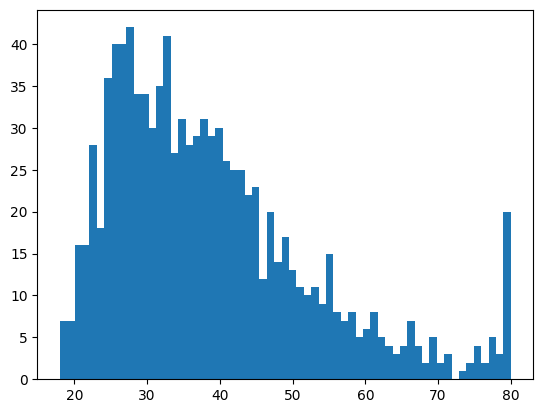

In [ ]:

#Test_Dataset_Values(set_Size=100000, a=1/20000, c=-0.065, dose_Beta=0.3/30, econ_Beta=np.log(0.8), smoke_Beta=np.log(0.75), sex_Beta=np.log(0.8), output="p", sort='Dosage', ascending=True, decimal_Precision=6)
E1 = EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
E2 = EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
E3 = EventObj(alpha=(1/15000), dose_Beta=(0.3/30), smoke_Beta=(np.log(0.75)), econ_Beta=0.09, sex_Beta=np.log(0.8), c=-0.035)
DF = Test_Dataset_Values(set_size=1000, e1_params=E1, e2_params=E2, e3_params=E3, sort='-ID', ascending=False, decimal_precision=4)
DF.printSchema()
DF.show()
# print(f"Total Person Years: {DF.count()}\"")
DF0 = DF.toPandas().groupby(['-ID']).max()
temp = DF0['Age']
# print(temp)
plt.hist(temp,bins=np.linspace(18,80,80-18))
plt.show()